In [5]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [50]:
Image_size=256
Batch_size=32
CHANNELS=3
EPOCHS=50

In [11]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
   "PlantVillage",
    shuffle=True,
    image_size=(Image_size,Image_size),
    batch_size=Batch_size
)

Found 2152 files belonging to 3 classes.


In [17]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [13]:
len(dataset)

68

In [19]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    print(image_batch[0].shape)

(32, 256, 256, 3)
[0 0 0 0 0 1 2 1 1 0 2 0 0 0 1 1 1 1 0 0 2 1 0 1 1 0 1 1 0 1 0 1]
(256, 256, 3)


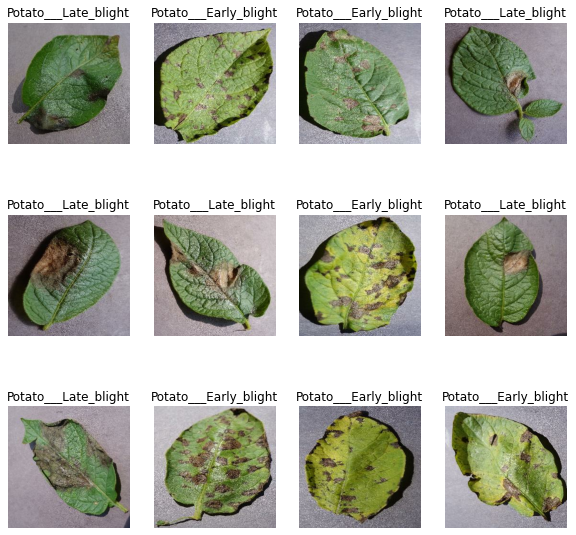

In [29]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [30]:
train_size=0.8
len(dataset)*train_size

54.400000000000006

In [31]:
train_ds=dataset.take(54)

In [32]:
len(train_ds)

54

In [33]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [34]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [35]:
val_ds=test_ds.take(6)
len(val_ds)

6

In [36]:
test_ds=test_ds.skip(6)
len(test_ds)

8

In [39]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1, shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds

In [40]:
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [42]:
len(train_ds)

54

In [43]:
len(val_ds)

6

In [44]:
len(test_ds)

8

In [46]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [47]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_size,Image_size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [48]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
    
])

In [52]:
input_shape=(Batch_size,Image_size,Image_size,CHANNELS)
n_classes=3
model=models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
    
])

model.build(input_shape=input_shape)

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [54]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [56]:
history = model.fit(
    train_ds,
    batch_size=Batch_size,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 93s 2s/step - loss: 0.9108 - accuracy: 0.4826 - val_loss: 0.9133 - val_accuracy: 0.4583
Epoch 2/50
54/54 [==============================] - 89s 2s/step - loss: 0.7390 - accuracy: 0.6748 - val_loss: 0.4843 - val_accuracy: 0.8177
Epoch 3/50
54/54 [==============================] - 85s 2s/step - loss: 0.4522 - accuracy: 0.8200 - val_loss: 0.3502 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 78s 1s/step - loss: 0.3294 - accuracy: 0.8582 - val_loss: 0.2367 - val_accuracy: 0.9167
Epoch 5/50
54/54 [==============================] - 83s 2s/step - loss: 0.2315 - accuracy: 0.9149 - val_loss: 0.1963 - val_accuracy: 0.9375
Epoch 6/50
54/54 [==============================] - 85s 2s/step - loss: 0.2044 - accuracy: 0.9242 - val_loss: 0.1764 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 85s 2s/step - loss: 0.1634 - accuracy: 0.9381 - val_loss: 0.1281 - val_accuracy: 0.9531
Epoch 8/50
54/54 [==

In [58]:
scores=model.evaluate(test_ds)

8/8 [==============================] - 5s 465ms/step - loss: 0.0691 - accuracy: 0.9727


In [59]:
scores

[0.06907416880130768, 0.97265625]

In [60]:
history

In [61]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [62]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [65]:
type(history.history['loss'])

list

In [66]:

len(history.history['loss'])

50

In [67]:
history.history['loss'][:5]

[0.9108104109764099,
 0.7390499114990234,
 0.45219162106513977,
 0.3293752074241638,
 0.2315140962600708]

In [68]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

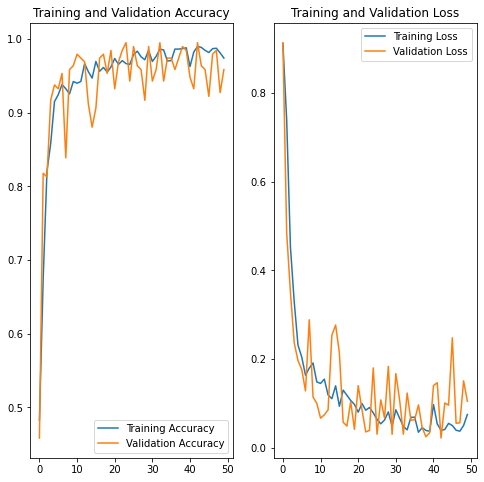

In [69]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___healthy
1/1 [==============================] - 1s 596ms/step
predicted label: Potato___healthy


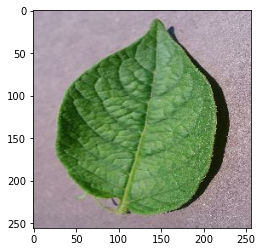

In [70]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [71]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 34ms/step


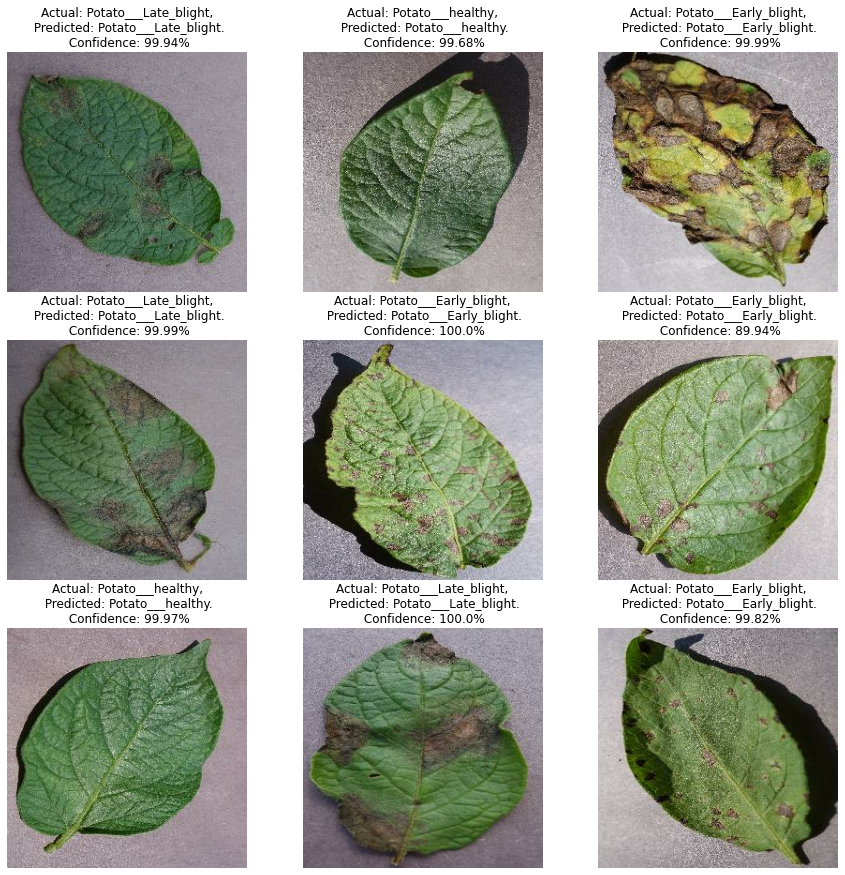

In [72]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [75]:
import os
model_version=max([int(i) for i in os.listdir("./models") + [0]])+1
model.save(f"./models/{model_version}")

INFO:tensorflow:Assets written to: ./models/1\assets


INFO:tensorflow:Assets written to: ./models/1\assets
